# Name Homogenizer

We have two csv files to start with. One contains information about cocoa producers contained in a pdf released by the govenrmnet of Ivory Coast. The other contains information about cocoa producers collected from large cocoa importers (e.g. Ferrero, Olam, Nestle, ...). In order to merge the datasets, we need to find all possible row combinations between the CSVs which describe the same entity. <br>

This project aims to fulfill this using LLMs to classify which name pairs are describing the same entity starting with just their text. Each method tested is benchmarked against a hand annotated dataset of __ examples.  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read CSV files into DataFrames
producers_1 = pd.read_csv('data/raw/ivorian-cocoa-coop-registry-2017.csv')
producers_2 = pd.read_csv('data/raw/cocoa-suppliers-compiled-from-importers.csv')

## Quick Look at Raw Data

In [3]:
producers_1

,Region,District,Producer Name,Abbreviation Name,Activity_Type,President_Name,Contact
0,SUD COMOE,SAN-PEDRO,AFRIKANISCHE UND IVORISCHE NACHHALTIGE KAFFEE\...,AFRIKA BA,PRODUCTION- COLLECTE-ACHAT- COMMERCIALISATION,KOFFI GERALD,07 72 36 20
1,SUD COMOE,SAN-PEDRO,AGRICOLE EMERGENCE-PLUS DE SAN PEDRO,AEPSP,PRODUCTION- COLLECTE-ACHAT- COMMERCIALISATION,FADIGA ALY,09 95 48 81
2,GÔH,GAGNOA,ALLIANCE COOPERATIVE AGRICOLE DE DOUKOUYO,ACAD SCOOPS,PRODUCTION-COLLECTE- COMMERCIALISATION,KONATE BOUKARY,07 07 27 98
3,AGNEBY- TIASSA,AGBOVILLE,ALLIANCE DE DEVELOPPEMENT AGRO-PASTORAL DE L’A...,ADAPA SCOOPS,PRESTATION- COLLECTE- COMMERCIALISATION,KOUAME ABISSI RAYMOND,49 07 06 87\n49 18 55 00\n48 41 25 13\n08 65 6...
4,GÔH,GAGNOA,ASSOCIATION COOPERATIVE AGRICOLE DU FROMAGER,SCOOPS ASCOOPAF,PRODUCTION-COLLECTE- COMMERCIALISATION,DAH OMBITE,07 75 91 89\n44 56 96 96
...,...,...,...,...,...,...,...
3126,NaN,SEGUELA,SOCIETE COOPERATIVE IVOIRIENNE D’EXPLOITATION ...,COOP-CA ENTRAIDE,PRODUCTION-COLLECTE- COMMERCIALISATION,KABRE ALI,49 07 21 18
3127,NaN,SEGUELA,SOCIETE COOPERATIVE YEBE DE SEGUELA,SCOOPS WINPAS,PRODUCTION- COLLECTE-ACHAT- COMMERCIALISATION,TOUGMA IGNACE,08 14 48 43\n45 53 44 55
3128,NaN,SEGUELA,SOCIETE COOPERATIVE WORODOUGOUKA,COOPEXPORT COOP-CA,PRODUCTION-COLLECTE- COMMERCIALISATION,KOUADIO KONAN MARCEL,08 01 06 03
3129,NaN,NaN,NaN,SOCAYS SCOOPS,PRODUCTION-COLLECTE- COMMERCIALISATION,KONE ZANA ALI,48 61 36 24\n46 65 61 92


In [4]:
producers_2

,Tier 1 Suppliers,Producer Name,Abbreviation Name,Region,Country,Source
0,Barry Callebaut AG,NaN,duekoue nord-bio,NaN,NaN,https://www.nestle.com/sites/default/files/ass...
1,Barry Callebaut AG,NaN,cabzou coop-ca,NaN,NaN,https://www.nestle.com/sites/default/files/ass...
2,Barry Callebaut AG,NaN,cexpag coop-ca,NaN,NaN,https://www.nestle.com/sites/default/files/ass...
3,Barry Callebaut AG,NaN,cootien-ouly,NaN,NaN,https://www.nestle.com/sites/default/files/ass...
4,Barry Callebaut AG,NaN,coop-ca abo,NaN,NaN,https://www.nestle.com/sites/default/files/ass...
...,...,...,...,...,...,...
615,Olam International Limited,Société Coopérative des Producteurs pour la Du...,SOCOPDAL SCOOPS,Lakota,NaN,https://www.olamgroup.com/content/dam/olamgrou...
616,Olam International Limited,Société Coopérative Agricole Entente de Karié,SOCOPEK,Karie,NaN,https://www.olamgroup.com/content/dam/olamgrou...
617,Olam International Limited,Société Coopérative Solidarité de Mahino,SOCOSOM-COOP-CA,Mahino,NaN,https://www.olamgroup.com/content/dam/olamgrou...
618,Olam International Limited,Union des Producteurs Agricoles de San Pedro,UPAS COOP CA,Gagny,NaN,https://www.olamgroup.com/content/dam/olamgrou...


## Missingness

producers 1: (3131, 7)
producers 2: (620, 6)


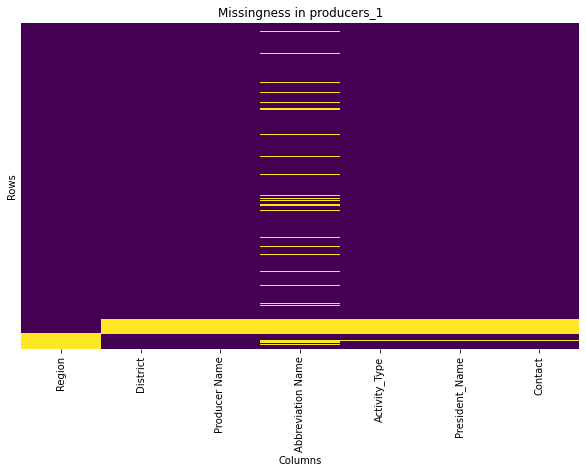

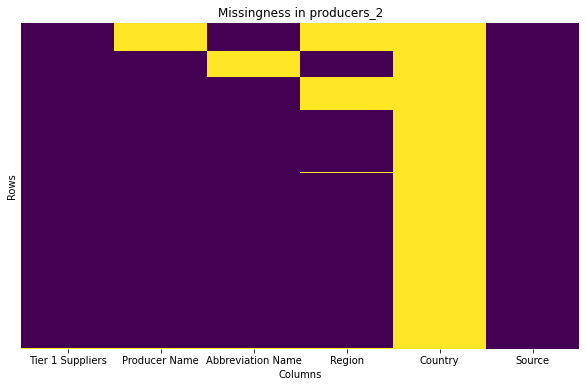


Percentage of missing values in producers_1:
Region                4.758863
District              4.758863
Producer Name         4.758863
Abbreviation Name    11.050782
Activity_Type         4.694986
President_Name        4.694986
Contact               4.694986
dtype: float64

Percentage of missing values in producers_2:
Tier 1 Suppliers       0.161290
Producer Name          9.032258
Abbreviation Name      8.387097
Region                19.193548
Country              100.000000
Source                 0.000000
dtype: float64


In [5]:
# Define function to plot missingness heatmap
def plot_missingness(df, title):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title(f'Missingness in {title}')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.show()

# Plot missingness for each DataFrame
print(f'producers 1: {producers_1.shape}')
print(f'producers 2: {producers_2.shape}')
plot_missingness(producers_1, 'producers_1')
plot_missingness(producers_2, 'producers_2')

# Calculate and print percentage of missing values for each DataFrame
for name, df in [('producers_1', producers_1), ('producers_2', producers_2)]:
    print(f"\nPercentage of missing values in {name}:")
    print(df.isnull().sum() / len(df) * 100)


## Clean

In [6]:
from homogenize import clean_and_output_csv, standardize_name

producers_1 = clean_and_output_csv(
    'data/raw/producers-gov.csv', 
    'data/clean/producers-gov.csv'
)
producers_2 = clean_and_output_csv(
    'data/raw/producers-importer.csv', 
    'data/clean/producers-importer.csv'
)

producers 1: (2777, 7)
producers 2: (514, 5)


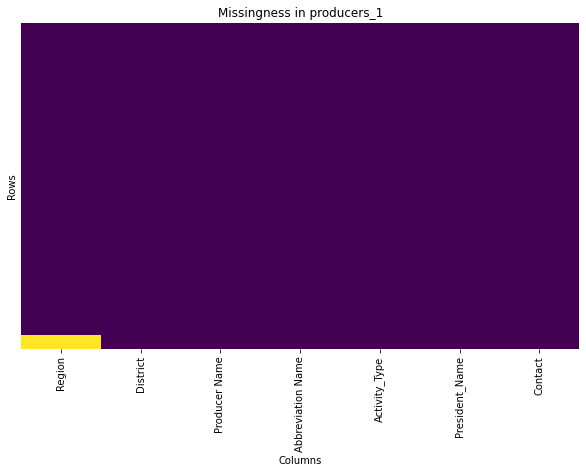

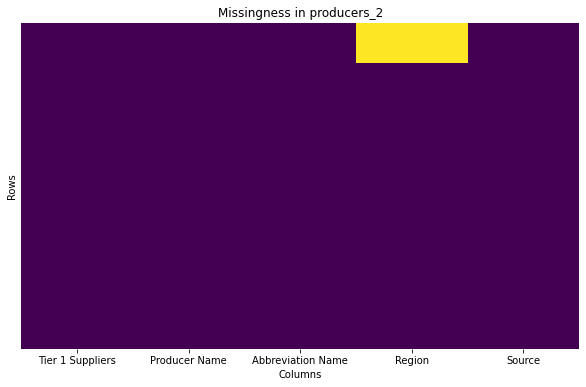


Percentage of missing values in producers_1:
Region               4.39323
District             0.00000
Producer Name        0.00000
Abbreviation Name    0.00000
Activity_Type        0.00000
President_Name       0.00000
Contact              0.00000
dtype: float64

Percentage of missing values in producers_2:
Tier 1 Suppliers      0.000000
Producer Name         0.000000
Abbreviation Name     0.000000
Region               12.451362
Source                0.000000
dtype: float64


In [7]:
# Define function to plot missingness heatmap
def plot_missingness(df, title):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title(f'Missingness in {title}')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.show()

# Plot missingness for each DataFrame
print(f'producers 1: {producers_1.shape}')
print(f'producers 2: {producers_2.shape}')
plot_missingness(producers_1, 'producers_1')
plot_missingness(producers_2, 'producers_2')

# Calculate and print percentage of missing values for each DataFrame
for name, df in [('producers_1', producers_1), ('producers_2', producers_2)]:
    print(f"\nPercentage of missing values in {name}:")
    print(df.isnull().sum() / len(df) * 100)

In [9]:
producers_2

,Tier 1 Suppliers,Producer Name,Abbreviation Name,Region,Source
54,Barry Callebaut AG,societe cooperative avec conseil dadministrati...,None,Agnibilekrou,https://www.lindt-spruengli.com/amfile/file/do...
55,Barry Callebaut AG,societe cooperative avec conseil dadministrati...,None,Abengourou,https://www.lindt-spruengli.com/amfile/file/do...
56,Barry Callebaut AG,societe cooperative agricole ahuanou darrah av ca,None,Bongouanou,https://www.lindt-spruengli.com/amfile/file/do...
57,Barry Callebaut AG,societe cooperative agricole guelanin avec con...,None,Bangolo,https://www.lindt-spruengli.com/amfile/file/do...
58,Barry Callebaut AG,societe cooperative agricole imaah societe coo...,None,Divo,https://www.lindt-spruengli.com/amfile/file/do...
...,...,...,...,...,...
614,Olam International Limited,societe cooperative agricole de watte,socopawa,Watté,https://www.olamgroup.com/content/dam/olamgrou...
615,Olam International Limited,societe cooperative des producteurs pour la du...,socopdal scoops,Lakota,https://www.olamgroup.com/content/dam/olamgrou...
616,Olam International Limited,societe cooperative agricole entente de karie,socopek,Karie,https://www.olamgroup.com/content/dam/olamgrou...
617,Olam International Limited,societe cooperative solidarite de mahino,socosomcoopca,Mahino,https://www.olamgroup.com/content/dam/olamgrou...


## Find Exact Matches

In [8]:
from homogenize import find_exact_matches_csv

output_csv_path = 'data/outputs/exact_matches.csv'
exact_matches_df = find_exact_matches_csv(
    producers_1, 
    producers_2, 
    output_csv_path
)

exact_matches_df: (72, 12)


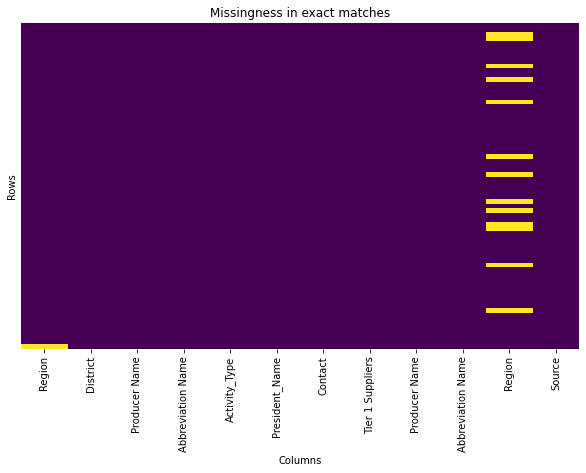


Percentage of missing values in exact matches:
Region                1.388889
District              0.000000
Producer Name         0.000000
Abbreviation Name     0.000000
Activity_Type         0.000000
President_Name        0.000000
Contact               0.000000
Tier 1 Suppliers      0.000000
Producer Name         0.000000
Abbreviation Name     0.000000
Region               18.055556
Source                0.000000
dtype: float64


In [9]:
# Plot missingness for each DataFrame
print(f'exact_matches_df: {exact_matches_df.shape}')
plot_missingness(exact_matches_df, 'exact matches')

# Calculate and print percentage of missing values for each DataFrame
for name, df in [('exact matches', exact_matches_df)]:
    print(f"\nPercentage of missing values in {name}:")
    print(df.isnull().sum() / len(df) * 100)


## Generate Name Pairs

Find the cartesian product of our two datasets to generate all the pairs we need to test. 

In [10]:
from homogenize import cartesian_product

producers_1 = pd.read_csv('data/clean/producers-gov.csv')
producers_2 = pd.read_csv('data/clean/producers-importer.csv')

pairs = cartesian_product(producers_1, producers_2, 'data/outputs/all_pairs.csv')

## Vector Silarity Tests

Here we'll be using semantic similarity and TF-IDF vectors to embed the producer names find each pair's cosine similarity. A high similarity should indicate a higher likelihood that the names represent the same entity. We'll define thresholds for each method and use the results to generate an eval set with many difficult cases. <br> 

Since we only need the Producer names and abbreviations, we'll start by pulling those out of the all_pairs csv.

In [1]:
import pandas as pd

In [2]:
try:
    pairs
except NameError:
    pairs = pd.read_csv('data/outputs/all_pairs.csv')

pairs = pairs[['Producer Name_x', 'Abbreviation Name_x', 'Producer Name_y', 'Abbreviation Name_y']]
pairs.shape

/tmp/ipykernel_151/1820070784.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  pairs = pd.read_csv('data/outputs/all_pairs.csv')


(1427378, 4)

Below you should see that there are no nulls in the name pairs since they should have all been removed during cleaning. 

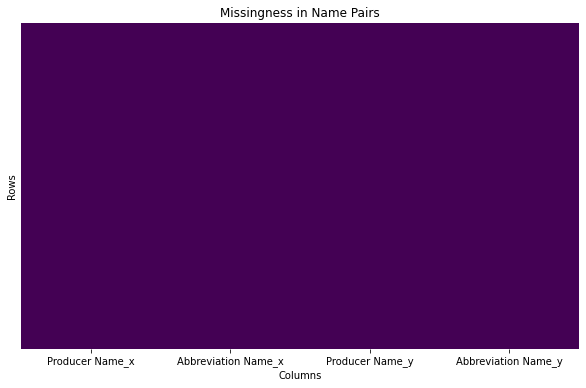

In [13]:
plot_missingness(pairs, 'Name Pairs')

Now, we'll run all similarity tests.

In [ ]:
from semantic_similarity import create_similarity_data

# Sample size
SAMPLE_SIZE = 500_000
processed_pairs = create_similarity_data(pairs, SAMPLE_SIZE, 'data/outputs/pair_similarity.csv')

/home/mperona/.local/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-10-30 15:07:10.520249: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Semantic Similarity

Here we measure the semantic similarity between names of producers to see whether a threshold can reasonably classify which names pairs are the same. 

In [1]:
import pandas as pd

try:
    processed_pairs
except NameError:
    processed_pairs = pd.read_csv('data/outputs/pair_similarity.csv')

processed_pairs.describe()

,tf_idf_similarity_name,semantic_similarity_name,second_half_similarity_name,second_half_weighted_similarity
count,250000.000000,250000.000000,250000.000000,250000.000000
mean,0.047012,0.619417,0.352008,0.485713
std,0.052823,0.137601,0.144011,0.122493
min,0.000000,-0.047489,-0.207100,-0.049703
25%,0.021311,0.541096,0.255312,0.408155
50%,0.035211,0.636809,0.340108,0.486357
75%,0.056195,0.716261,0.434237,0.563073
max,1.000000,1.000000,1.000000,1.000000


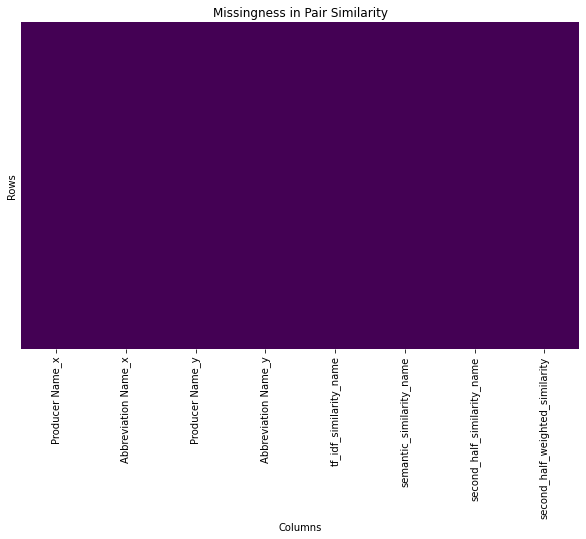

In [2]:
from vis import plot_missingness

plot_missingness(processed_pairs, 'Pair Similarity')

In [3]:
processed_pairs.columns

Index(['Producer Name_x', 'Abbreviation Name_x', 'Producer Name_y',
       'Abbreviation Name_y', 'tf_idf_similarity_name',
       'semantic_similarity_name', 'second_half_similarity_name',
       'second_half_weighted_similarity'],
      dtype='object')

In [4]:
processed_pairs = processed_pairs.sort_values(by='semantic_similarity_name', ascending=False)
        
for i in range(100):
    row = processed_pairs.iloc[i]
    print(f"{row['Producer Name_x']:<50} | {row['Producer Name_y']:<50} | {row['semantic_similarity_name']:.4f} | {row['Abbreviation Name_x']:<10} | {row['Abbreviation Name_y']:<10} ")

with open('data/outputs/semantic_similarity_name.txt', 'w') as f:
    for i in range(100):
        row = processed_pairs.iloc[i]
        f.write(f"{row['Producer Name_x']:<70} | {row['Producer Name_y']:<70} | {row['semantic_similarity_name']:.4f} | {row['Abbreviation Name_x']:<10} | {row['Abbreviation Name_y']:<10}\n")


cooperative agricole des producteurs de divo       | cooperative agricole des producteurs de divo       | 1.0000 | coopapd coop-ca | coopradi   
societe cooperative agricole sinikan               | societe cooperative agricole sinikan               | 1.0000 | coopas     | sinikan-scoopas 
societe cooperative agricole de kouibly            | societe cooperative agricole de kouibly            | 1.0000 | socak scoops | socas      
nouvelle entreprise cooperative agricole de bagolieoua | nouvelle entreprise cooperative agricole de bagolieoua | 1.0000 | coop-ca necab | coop-ca necab 
cooperative agricole des producteurs de divo       | cooperative agricole des producteurs de divo       | 1.0000 | coopapd coop-ca | coopradi   
societe cooperative des agriculteurs de soubre     | societe cooperative des agriculteurs de soubre     | 1.0000 | socags     | socags     
societe cooperative agricole de guitry             | societe cooperative agricole de guitry             | 1.0000 | coop-ca socoag

One thing we can notice immediately is that the way the string starts seems to heavily sway the similarity resulting similarity measure. The second half of each name seems more relevant to determining sameness, so we'll process another sample looking at the semantic similarity of only the second half of each name. 

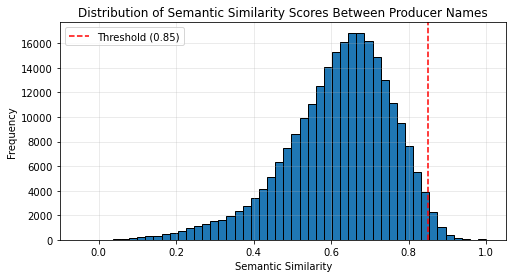

Percentage of pairs with similarity > 0.85: 1.76%


In [5]:
from vis import similarity_hist

similarity_hist(
    df=processed_pairs, 
    column='semantic_similarity_name', 
    title='Distribution of Semantic Similarity Scores Between Producer Names', 
    threshold= 0.85
)

#### Second Half Similarity

In [6]:
processed_pairs = processed_pairs.sort_values(by='second_half_similarity_name', ascending=False)

# Print the results side by side        
for i in range(100):
    row = processed_pairs.iloc[i]
    print(f"{row['Producer Name_x']:<50} | {row['Producer Name_y']:<50} | {row['second_half_similarity_name']:.4f} | {row['Abbreviation Name_x']:<10} | {row['Abbreviation Name_y']:<10} ")

with open('data/outputs/second_half_similarity_name.txt', 'w') as f:
    for i in range(100):
        row = processed_pairs.iloc[i]
        f.write(f"{row['Producer Name_x']:<70} | {row['Producer Name_y']:<70} | {row['second_half_similarity_name']:.4f} | {row['Abbreviation Name_x']:<10} | {row['Abbreviation Name_y']:<10}\n")


societe cooperative agricole de kouibly            | societe cooperative agricole de kouibly            | 1.0000 | socak scoops | socas      
cooperative du pardon                              | societe cooperative du pardon                      | 1.0000 | scoopa scoops | scoopa     
societe cooperative soubreenne des producteurs agricoles | societe cooperative soubreenne des producteurs agricoles | 1.0000 | scspa coop ca | scspa      
societe cooperative agricole de dogbo              | societe cooperative agricole de dogbo              | 1.0000 | socopadogbo  coop-ca | socopadogbo 
societe cooperative de meagui                      | cooperative victoire de meagui                     | 1.0000 | socoom     | covimea    
societe cooperative agricole lanaya de vavoua      | societe cooperative agricole lanaya de vavoua      | 1.0000 | scalava coop-ca | scalava    
societe cooperative agricole akayara de datta      | ste coop agri akayara de datta                     | 1.0000 | coop-ca s

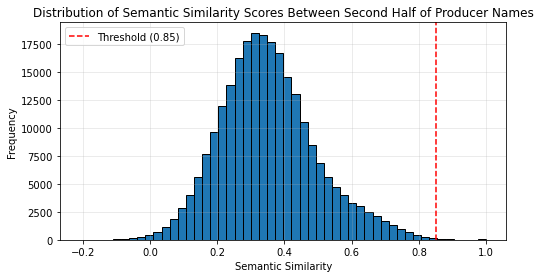

Percentage of pairs with similarity > 0.85: 0.13%


In [7]:
similarity_hist(
    df=processed_pairs, 
    column='second_half_similarity_name', 
    title='Distribution of Semantic Similarity Scores Between Second Half of Producer Names', 
    threshold= 0.85
)

We got more exact matches, but lower overall similarity for the whole set. This is expected. Let's see what happens when we average the second half similarity with that of the first half.

In [8]:
processed_pairs = processed_pairs.sort_values(by='second_half_weighted_similarity', ascending=False)

# Print the results side by side        
for i in range(100):
    row = processed_pairs.iloc[i]
    print(f"{row['Producer Name_x']:<50} | {row['Producer Name_y']:<50} | {row['second_half_weighted_similarity']:.4f} | {row['Abbreviation Name_x']:<10} | {row['Abbreviation Name_y']:<10} ")

with open('data/outputs/second_half_weighted_similarity.txt', 'w') as f:
    for i in range(100):
        row = processed_pairs.iloc[i]
        f.write(f"{row['Producer Name_x']:<70} | {row['Producer Name_y']:<70} | {row['second_half_weighted_similarity']:.4f} | {row['Abbreviation Name_x']:<10} | {row['Abbreviation Name_y']:<10}\n")


societe cooperative agricole de kouibly            | societe cooperative agricole de kouibly            | 1.0000 | socak scoops | socas      
societe cooperative soubreenne des producteurs agricoles | societe cooperative soubreenne des producteurs agricoles | 1.0000 | scspa coop ca | scspa      
societe cooperative agricole de dogbo              | societe cooperative agricole de dogbo              | 1.0000 | socopadogbo  coop-ca | socopadogbo 
cooperative agricole des producteurs de divo       | cooperative agricole des producteurs de divo       | 1.0000 | coopapd coop-ca | coopradi   
cooperative agricole des producteurs de divo       | cooperative agricole des producteurs de divo       | 1.0000 | coopapd coop-ca | coopradi   
societe cooperative agricole sinikan               | societe cooperative agricole sinikan               | 1.0000 | coopas     | sinikan-scoopas 
societe cooperative agricole de guitry             | societe cooperative agricole de guitry             | 1.0000 | so

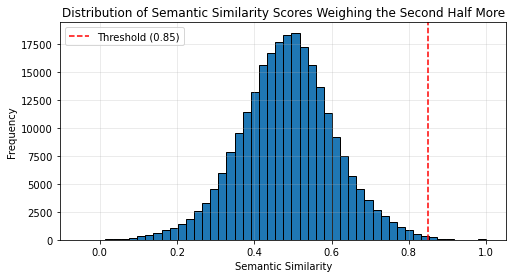

Percentage of pairs with similarity > 0.85: 0.19%


In [9]:
similarity_hist(
    df=processed_pairs, 
    column='second_half_weighted_similarity', 
    title='Distribution of Semantic Similarity Scores Weighing the Second Half More', 
    threshold= 0.85
)

### TF-IDF Vector Similarity

In [10]:
processed_pairs = processed_pairs.sort_values(by='tf_idf_similarity_name', ascending=False)

# Print the results side by side        
for i in range(100):
    row = processed_pairs.iloc[i]
    print(f"{row['Producer Name_x']:<50} | {row['Producer Name_y']:<50} | {row['tf_idf_similarity_name']:.4f} | {row['Abbreviation Name_x']:<10} | {row['Abbreviation Name_y']:<10} ")

with open('data/outputs/tf_idf_similarity_name.txt', 'w') as f:
    for i in range(100):
        row = processed_pairs.iloc[i]
        f.write(f"{row['Producer Name_x']:<70} | {row['Producer Name_y']:<70} | {row['tf_idf_similarity_name']:.4f} | {row['Abbreviation Name_x']:<10} | {row['Abbreviation Name_y']:<10}\n")


societe cooperative des agriculteurs de soubre     | societe cooperative des agriculteurs de soubre     | 1.0000 | socags     | socags     
societe cooperative agricole de djoroplo           | societe cooperative agricole de djoroplo           | 1.0000 | coop-ca  socadjo | socadjo    
societe  cooperative des producteurs agricole  du sanwi | societe cooperative des producteurs agricole du sanwi | 1.0000 | scoopras  coop-ca | coopras    
cooperative agricole de lassina bango              | cooperative agricole de lassina bango              | 1.0000 | coopalba coop-ca | coopalba   
societe cooperative agricole de kouibly            | societe cooperative agricole de kouibly            | 1.0000 | socak scoops | socas      
societe cooperative agricole lanaya de vavoua      | societe cooperative agricole lanaya de vavoua      | 1.0000 | scalava coop-ca | scalava    
cooperative agricole siboulaka de beoua            | cooperative agricole siboulaka de beoua            | 1.0000 | c.asi.b sco

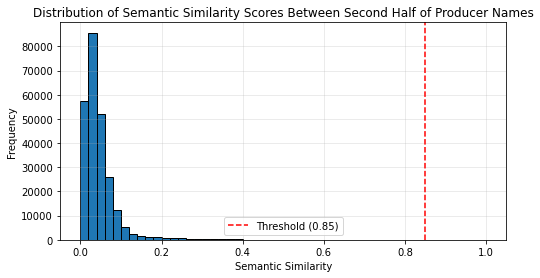

Percentage of pairs with similarity > 0.85: 0.02%


In [11]:
similarity_hist(
    df=processed_pairs, 
    column='tf_idf_similarity_name', 
    title='Distribution of Semantic Similarity Scores Between Second Half of Producer Names', 
    threshold= 0.85
)

Looking through the outputs we can tell that the thresholds are not good enough at telling when two names are the same. It's worth building an eval set off of thresholds and testing LLMs.

## Create Eval Set 

In [12]:
def generate_eval_template(
    processed_pairs, 
    metrics=['second_half_weighted_similarity', 'tf_idf_similarity_name'], 
    output_csv_path='data/outputs/eval_template.csv', 
    n=100):
    
    # Find the top n rows ranked by each metric.
    top_n = []
    for metric in metrics:
        # Get the top n rows ranked by metric
        top_n.append(processed_pairs.sort_values(by=metric, ascending=False).head(n))
    
    # Concatenate the DataFrames and drop duplicate rows
    combined_top_n = pd.concat(top_n).drop_duplicates()

    # Add a column 'classification' and fill it with all 0
    combined_top_n['classification'] = 0

    # Select only the producer name and abbreviated name columns
    result = combined_top_n[['Producer Name_x', 'Producer Name_y', 'Abbreviation Name_x', 'Abbreviation Name_y', 'classification']]
    
    # Write results to csv
    result.to_csv(output_csv_path, index=False)
    
    return result

generate_eval_template(
    processed_pairs=processed_pairs,
    metrics=['second_half_weighted_similarity', 'tf_idf_similarity_name'], 
    output_csv_path='data/outputs/eval_template.csv',
    n=200
)
    

,Producer Name_x,Producer Name_y,Abbreviation Name_x,Abbreviation Name_y,classification
4,societe cooperative agricole de kouibly,societe cooperative agricole de kouibly,socak scoops,socas,0
7,cooperative agricole des producteurs de divo,cooperative agricole des producteurs de divo,coopapd coop-ca,coopradi,0
31,cooperative agricole des producteurs de divo,cooperative agricole des producteurs de divo,coopapd coop-ca,coopradi,0
3,societe cooperative agricole de dogbo,societe cooperative agricole de dogbo,socopadogbo coop-ca,socopadogbo,0
2,societe cooperative soubreenne des producteurs...,societe cooperative soubreenne des producteurs...,scspa coop ca,scspa,0
...,...,...,...,...,...
10387,societe cooperative agricole de youkou,societe cooperative agricole espoir de petit-g...,socayou,scaepgy,0
1304,societe cooperative des exploitants agricoles ...,societe cooperative agricole de soubre,ceaso scoops,scasou-coop-ca,0
845,cooperative agricole la renaissance de gadouan,cooperative agricole la renaissance de vavoua,carega,careva,0
844,cooperative agricole la renaissance de gadouan,cooperative agricole la renaissance de vavoua,carega,careva,0


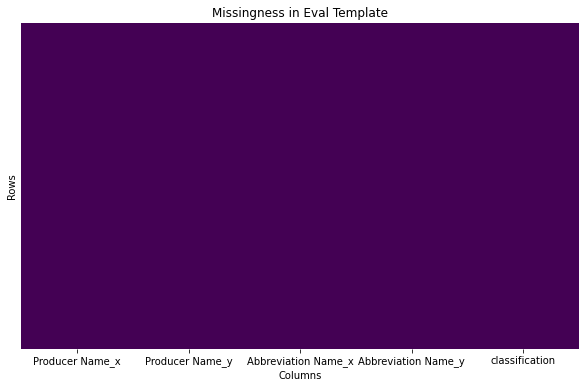

In [13]:
eval_template = pd.read_csv('data/outputs/eval_template.csv')
plot_missingness(eval_template, 'Eval Template')